In [3]:
!pip install transformers datasets scikit-learn pandas numpy matplotlib

In [4]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.0
    Uninstalling transformers-4.57.0:
      Successfully uninstalled transformers-4.57.0


In [5]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset

dataset = load_dataset("amazon_polarity", split="train[:20000]")
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 20000
})


In [7]:
import re

def clean_text(text):
    text = str(text)
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^A-Za-z0-9\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

In [8]:
df=dataset.to_pandas()[['content', 'label']]
df['clean_text'] = df['content'].apply(clean_text)
display(df.head(10))

,content,label,clean_text
0,This sound track was beautiful! It paints the ...,1,this sound track was beautiful! it paints the ...
1,I'm reading a lot of reviews saying that this ...,1,im reading a lot of reviews saying that this i...
2,This soundtrack is my favorite music of all ti...,1,this soundtrack is my favorite music of all ti...
3,I truly like this soundtrack and I enjoy video...,1,i truly like this soundtrack and i enjoy video...
4,"If you've played the game, you know how divine...",1,"if youve played the game, you know how divine ..."
5,I am quite sure any of you actually taking the...,1,i am quite sure any of you actually taking the...
6,"This is a self-published book, and if you want...",0,"this is a selfpublished book, and if you want ..."
7,I loved Whisper of the wicked saints. The stor...,1,i loved whisper of the wicked saints. the stor...
8,I just finished reading Whisper of the Wicked ...,1,i just finished reading whisper of the wicked ...
9,This was a easy to read book that made me want...,1,this was a easy to read book that made me want...


In [9]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

dataset_hf=Dataset.from_pandas(df[['clean_text', 'label']])

def tokenize_function(examples):
    return tokenizer(
        examples["clean_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_dataset=dataset_hf.map(tokenize_function, batched=True)

print(tokenized_dataset[0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

{'clean_text': 'this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen!', 'label': 1, 'input_ids': [101, 2023, 2614, 2650, 2001, 3376, 999, 2009, 23262, 1996, 12411, 7301, 1999, 2115, 2568, 2061, 2092, 1045, 2052, 28667, 8462, 4859, 2009, 2130, 2000, 2111, 2040, 5223, 6819, 2094, 1012, 2208, 2189, 999, 1045, 2031, 2209, 1996, 2208, 10381, 4948, 2080, 2892, 2021, 2041, 1997, 2035, 1997, 1996, 2399, 1045, 2031, 2412, 2209, 2009, 2038, 1996, 2190, 2189, 999, 2009, 10457, 2185, 2013, 13587, 9019, 2075, 1998, 3138, 1037, 4840, 2121, 3357, 2007, 24665, 3686, 7334, 1998, 3969, 3993, 19505, 1012, 2009, 2052, 17894, 3087, 2040, 14977, 2000, 4952, 999, 102, 0, 0, 0, 

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import numpy as np
import evaluate
from datasets import Dataset


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)
def load_data_in_chunks():

    texts = ["Sample text " + str(i) for i in range(1000)]
    labels = [i % 2 for i in range(1000)]

    return Dataset.from_dict({"text": texts, "label": labels})


print("Loading data...")
dataset = load_data_in_chunks()


print("Tokenizing data...")
tokenized_dataset = dataset.map(tokenize_function, batched=True, batch_size=100)


split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)


print("Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)


accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",  # typo fix
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    dataloader_pin_memory=False,
    gradient_accumulation_steps=2,
)



import torch
torch.cuda.empty_cache() if torch.cuda.is_available() else None

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Starting training with memory optimizations...")
trainer.train()

Loading data...
Tokenizing data...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loading model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1845770866.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training with memory optimizations...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.417875,0.865000
2,No log,0.353316,0.865000


TrainOutput(global_step=100, training_loss=0.5216003036499024, metrics={'train_runtime': 205.2831, 'train_samples_per_second': 7.794, 'train_steps_per_second': 0.487, 'total_flos': 4933332288000.0, 'train_loss': 0.5216003036499024, 'epoch': 2.0})

In [12]:
!pip install shap matplotlib

In [20]:
import shap
import torch

sample_texts=[
    "I absolutely loved this product! It's amazing.",
    "Terrible quality, waste of money",
    "pretty decent for the price",
    "I wouldn't recommend this to anyone."
]

def predict(texts):
  # Ensure input is a list of strings, handling potential non-string inputs from masker
  if isinstance(texts, str):
      texts = [texts]
  elif isinstance(texts, list) and all(isinstance(t, str) for t in texts):
      pass # Already list of strings
  else:
      # Attempt to convert to list of strings, handling potential complex types
      try:
          texts = [str(t) for t in texts]
      except:
          print("Warning: Could not convert input to list of strings in predict function.")
          return None # Or handle error appropriately

  inputs=tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
  outputs=model(**inputs)
  probs=torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()
  return probs

masker = shap.maskers.Text(tokenizer, mask_token="[MASK]")
explainer = shap.Explainer(predict, masker)

shap_values=explainer(sample_texts)

shap.plots.text(shap_values)

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [00:14<00:00,  1.01s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [00:21,  5.47s/it]


Accuracy: 0.865
Precision: 0.866
Recall: 0.865
F1 Score: 0.865


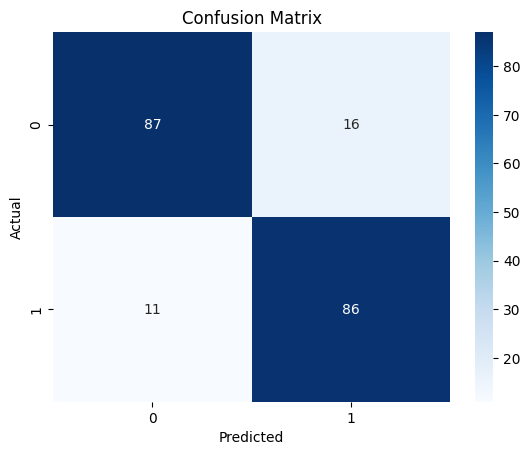

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get test dataset
test_dataset = split_dataset["test"]

# Make predictions
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(-1)
labels = preds_output.label_ids

# Compute metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
sample_texts=[test_dataset[i]["text"] for i in range (10)]
model_preds=[int(preds[i]) for i in range (10)]

def gpt4(text):
  prompt=f"Classify the sentiment of this text as Positive or Negative:\n\n{text}"
  response=openai.chat.completions.create(
      model="gpt-4o-mini",
      messages=[{"role":"user", "content":prompt}],
      temperature=0
  )
  reply=response.choices[0].message.content.strip().lower()
  return "positive" if "positive" in reply else "negative"

results=[]
for i, text in enumerate(sample_texts):
  gpt_label=gpt4(text)
  model_label="positive" if model_preds[i]==1 else "negative"
  results.append({"text": text, "BERT Prediction": model_label, "GPT-4 prediction": gpt_label})

pd.DataFrame(results)

,text,BERT Prediction,GPT-4 prediction
0,Sample text 978,positive,positive
1,Sample text 933,positive,positive
2,Sample text 859,positive,positive
3,Sample text 916,negative,positive
4,Sample text 127,positive,positive
5,Sample text 608,negative,positive
6,Sample text 856,negative,positive
7,Sample text 260,negative,positive
8,Sample text 147,positive,positive
9,Sample text 810,negative,positive


In [34]:
import openai, time, pandas as pd, numpy as np

from datasets import load_dataset

test_dataset= load_dataset("amazon_polarity", split="test[:50]")


def get_test_text(i):
  return test_dataset[i]["content"]

NUM_SAMPLES=50
indices=np.random.choice(len(test_dataset), NUM_SAMPLES, replace=False).tolist()

sample_texts=[get_test_text(i) for i in indices]

model_preds=[test_dataset[i]["label"] for i in indices]



# def get_test_text(i):
#   return split_dataset["test"][i]["text"]

# NUM_SAMPLES=50
# indices=list(range(min(NUM_SAMPLES, len(split_dataset["test"]))))

# sample_texts=[get_test_text(i) for i in indices]
# model_preds=[int (preds[i]) for i in indices]


def gpt4(text, retries=2, sleep=1.0):
  system=(
      "You are a sentiment annotation assistant."
      "Answer ONLY in exact JSON: {\"label\": \"Positive\"|\"Neutral\"|\"Negative\", \"confidence\": 0.0-1.0}."
      "Use confidence between 0 and 1. If uncertain, use \"Neutral\" with low confidence."
  )
  user=f"Text: \"{text}\"\n\nReturn the JSON only."
  for attempt in range(retries+1):
    try:
      resp=openai.chat.completions.create(
          model="gpt-4",
          messages=[{"role":"system", "content":system},
                    {"role":"user", "content":user}],
          temperature=0
      )
      text_out=resp.choices[0].message.content.strip()
      import json
      parsed=json.loads(text_out)
      label=parsed.get("label", "").lower()
      conf=float(parsed.get("confidence", 0.0))
      if "positive" in label:
        return "positive", conf
      if "negative" in label:
        return "negative", conf
      return "neutral", conf
    except Exception as e:
      if attempt<retries:
        time.sleep(sleep)
        sleep*=2
        continue
      print(f"Error processing text: {text[:50]}... Error: {e}")
      return "neutral", 0.0

gpt_labels = []
gpt_confs = []
for i, txt in enumerate(sample_texts):
    lab, conf = gpt4(txt)
    gpt_labels.append(lab)
    gpt_confs.append(conf)
    if (i+1) % 10 == 0:
        print(f"Queried {i+1}/{len(sample_texts)}")

df = pd.DataFrame({
    "text": sample_texts,
    "BERT_pred_label": ["positive" if p==1 else "negative" for p in model_preds],
    "GPT_label": gpt_labels,
    "GPT_conf": gpt_confs
})

df["agree"] = df["BERT_pred_label"] == df["GPT_label"]
agreement_rate = df["agree"].mean()
print(f"Agreement rate (BERT vs GPT-4) on {len(df)} samples: {agreement_rate:.3f}")

mismatches = df[df["agree"] == False].sample(min(10, len(df[df["agree"] == False])))
mismatches.reset_index(drop=True, inplace=True)
mismatches

Queried 10/50
Queried 20/50
Queried 30/50
Queried 40/50
Queried 50/50
Agreement rate (BERT vs GPT-4) on 50 samples: 0.980


,text,BERT_pred_label,GPT_label,GPT_conf,agree
0,"Firstly,I enjoyed the format and tone of the b...",negative,neutral,0.7,False
